# 769 Final Water Quality Detection

## Environment setup

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Machine Learning libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif, RFE, SelectFromModel
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from imblearn.over_sampling import SMOTE


# ML Models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression, Ridge, Lasso
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE

# Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Evaluation metrics
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                           classification_report, confusion_matrix, roc_auc_score,
                           roc_curve, precision_recall_curve, average_precision_score)

# Statistical tests
from scipy.stats import kstest, anderson, shapiro, levene, ttest_ind, mannwhitneyu

# Visualization
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")


In [ ]:
print(accuracy_score, precision_score, recall_score, f1_score, roc_auc_score)


<function accuracy_score at 0x7e9e334c2a20> <function precision_score at 0x7e9e334c3b00> <function recall_score at 0x7e9e334c3c40> <function f1_score at 0x7e9e334c32e0> <function roc_auc_score at 0x7e9e334ee7a0>


## Install and download dataset

In [ ]:
!pip install kagglehub --quiet

In [ ]:
import kagglehub
dataset_path = kagglehub.dataset_download("adityakadiwal/water-potability")
print(f"Dataset downloaded to: {dataset_path}")

import os
available_files = os.listdir(dataset_path)
print(f"Available files: {available_files}")

# Load the dataset
df = pd.read_csv(os.path.join(dataset_path, "water_potability.csv"))
print(f"Dataset loaded successfully!")
print(f"Dataset shape: {df.shape}")

100%|██████████| 251k/251k [00:00<00:00, 71.2MB/s]

Extracting files...
Dataset downloaded to: /root/.cache/kagglehub/datasets/adityakadiwal/water-potability/versions/3
Available files: ['water_potability.csv']
Dataset loaded successfully!
Dataset shape: (3276, 10)


## Basic information

In [ ]:
print(f"Number of samples: {df.shape[0]:,}")
print(f"Number of features: {df.shape[1]:,}")


Number of samples: 3,276
Number of features: 10


In [ ]:
print("\n📄 FIRST 10 ROWS:")
df.head(10)


📄 FIRST 10 ROWS:


,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0
5,5.584087,188.313324,28748.687739,7.544869,326.678363,280.467916,8.399735,54.917862,2.559708,0
6,10.223862,248.071735,28749.716544,7.513408,393.663396,283.651634,13.789695,84.603556,2.672989,0
7,8.635849,203.361523,13672.091764,4.563009,303.309771,474.607645,12.363817,62.798309,4.401425,0
8,NaN,118.988579,14285.583854,7.804174,268.646941,389.375566,12.706049,53.928846,3.595017,0
9,11.180284,227.231469,25484.508491,9.077200,404.041635,563.885481,17.927806,71.976601,4.370562,0


In [ ]:
# Data types and missing values
info_df = pd.DataFrame({
    'Data Type': df.dtypes,
    'Missing Count': df.isnull().sum(),
    'Missing Percentage': (df.isnull().sum() / len(df)) * 100,
    'Unique Values': df.nunique(),
    'Min Value': df.min(),
    'Max Value': df.max()
})
info_df

,Data Type,Missing Count,Missing Percentage,Unique Values,Min Value,Max Value
ph,float64,491,14.987790,2785,0.000000,14.000000
Hardness,float64,0,0.000000,3276,47.432000,323.124000
Solids,float64,0,0.000000,3276,320.942611,61227.196008
Chloramines,float64,0,0.000000,3276,0.352000,13.127000
Sulfate,float64,781,23.840049,2495,129.000000,481.030642
Conductivity,float64,0,0.000000,3276,181.483754,753.342620
Organic_carbon,float64,0,0.000000,3276,2.200000,28.300000
Trihalomethanes,float64,162,4.945055,3114,0.738000,124.000000
Turbidity,float64,0,0.000000,3276,1.450000,6.739000
Potability,int64,0,0.000000,2,0.000000,1.000000


In [ ]:
# Statistical summary
df.describe()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
count,2785.000000,3276.000000,3276.000000,3276.000000,2495.000000,3276.000000,3276.000000,3114.000000,3276.000000,3276.000000
mean,7.080795,196.369496,22014.092526,7.122277,333.775777,426.205111,14.284970,66.396293,3.966786,0.390110
std,1.594320,32.879761,8768.570828,1.583085,41.416840,80.824064,3.308162,16.175008,0.780382,0.487849
min,0.000000,47.432000,320.942611,0.352000,129.000000,181.483754,2.200000,0.738000,1.450000,0.000000
25%,6.093092,176.850538,15666.690297,6.127421,307.699498,365.734414,12.065801,55.844536,3.439711,0.000000
50%,7.036752,196.967627,20927.833607,7.130299,333.073546,421.884968,14.218338,66.622485,3.955028,0.000000
75%,8.062066,216.667456,27332.762127,8.114887,359.950170,481.792304,16.557652,77.337473,4.500320,1.000000
max,14.000000,323.124000,61227.196008,13.127000,481.030642,753.342620,28.300000,124.000000,6.739000,1.000000


In [ ]:
# Target variable analysis
print("TARGET VARIABLE ANALYSIS:")

target_counts = df['Potability'].value_counts()
target_percentages = df['Potability'].value_counts(normalize=True) * 100

print(f"Not Potable (0): {target_counts[0]:,} samples ({target_percentages[0]:.2f}%)")
print(f"Potable (1): {target_counts[1]:,} samples ({target_percentages[1]:.2f}%)")
print(f"Class Imbalance Ratio: {target_counts[0]/target_counts[1]:.2f}:1")


TARGET VARIABLE ANALYSIS:
Not Potable (0): 1,998 samples (60.99%)
Potable (1): 1,278 samples (39.01%)
Class Imbalance Ratio: 1.56:1


## Advanced exploratory

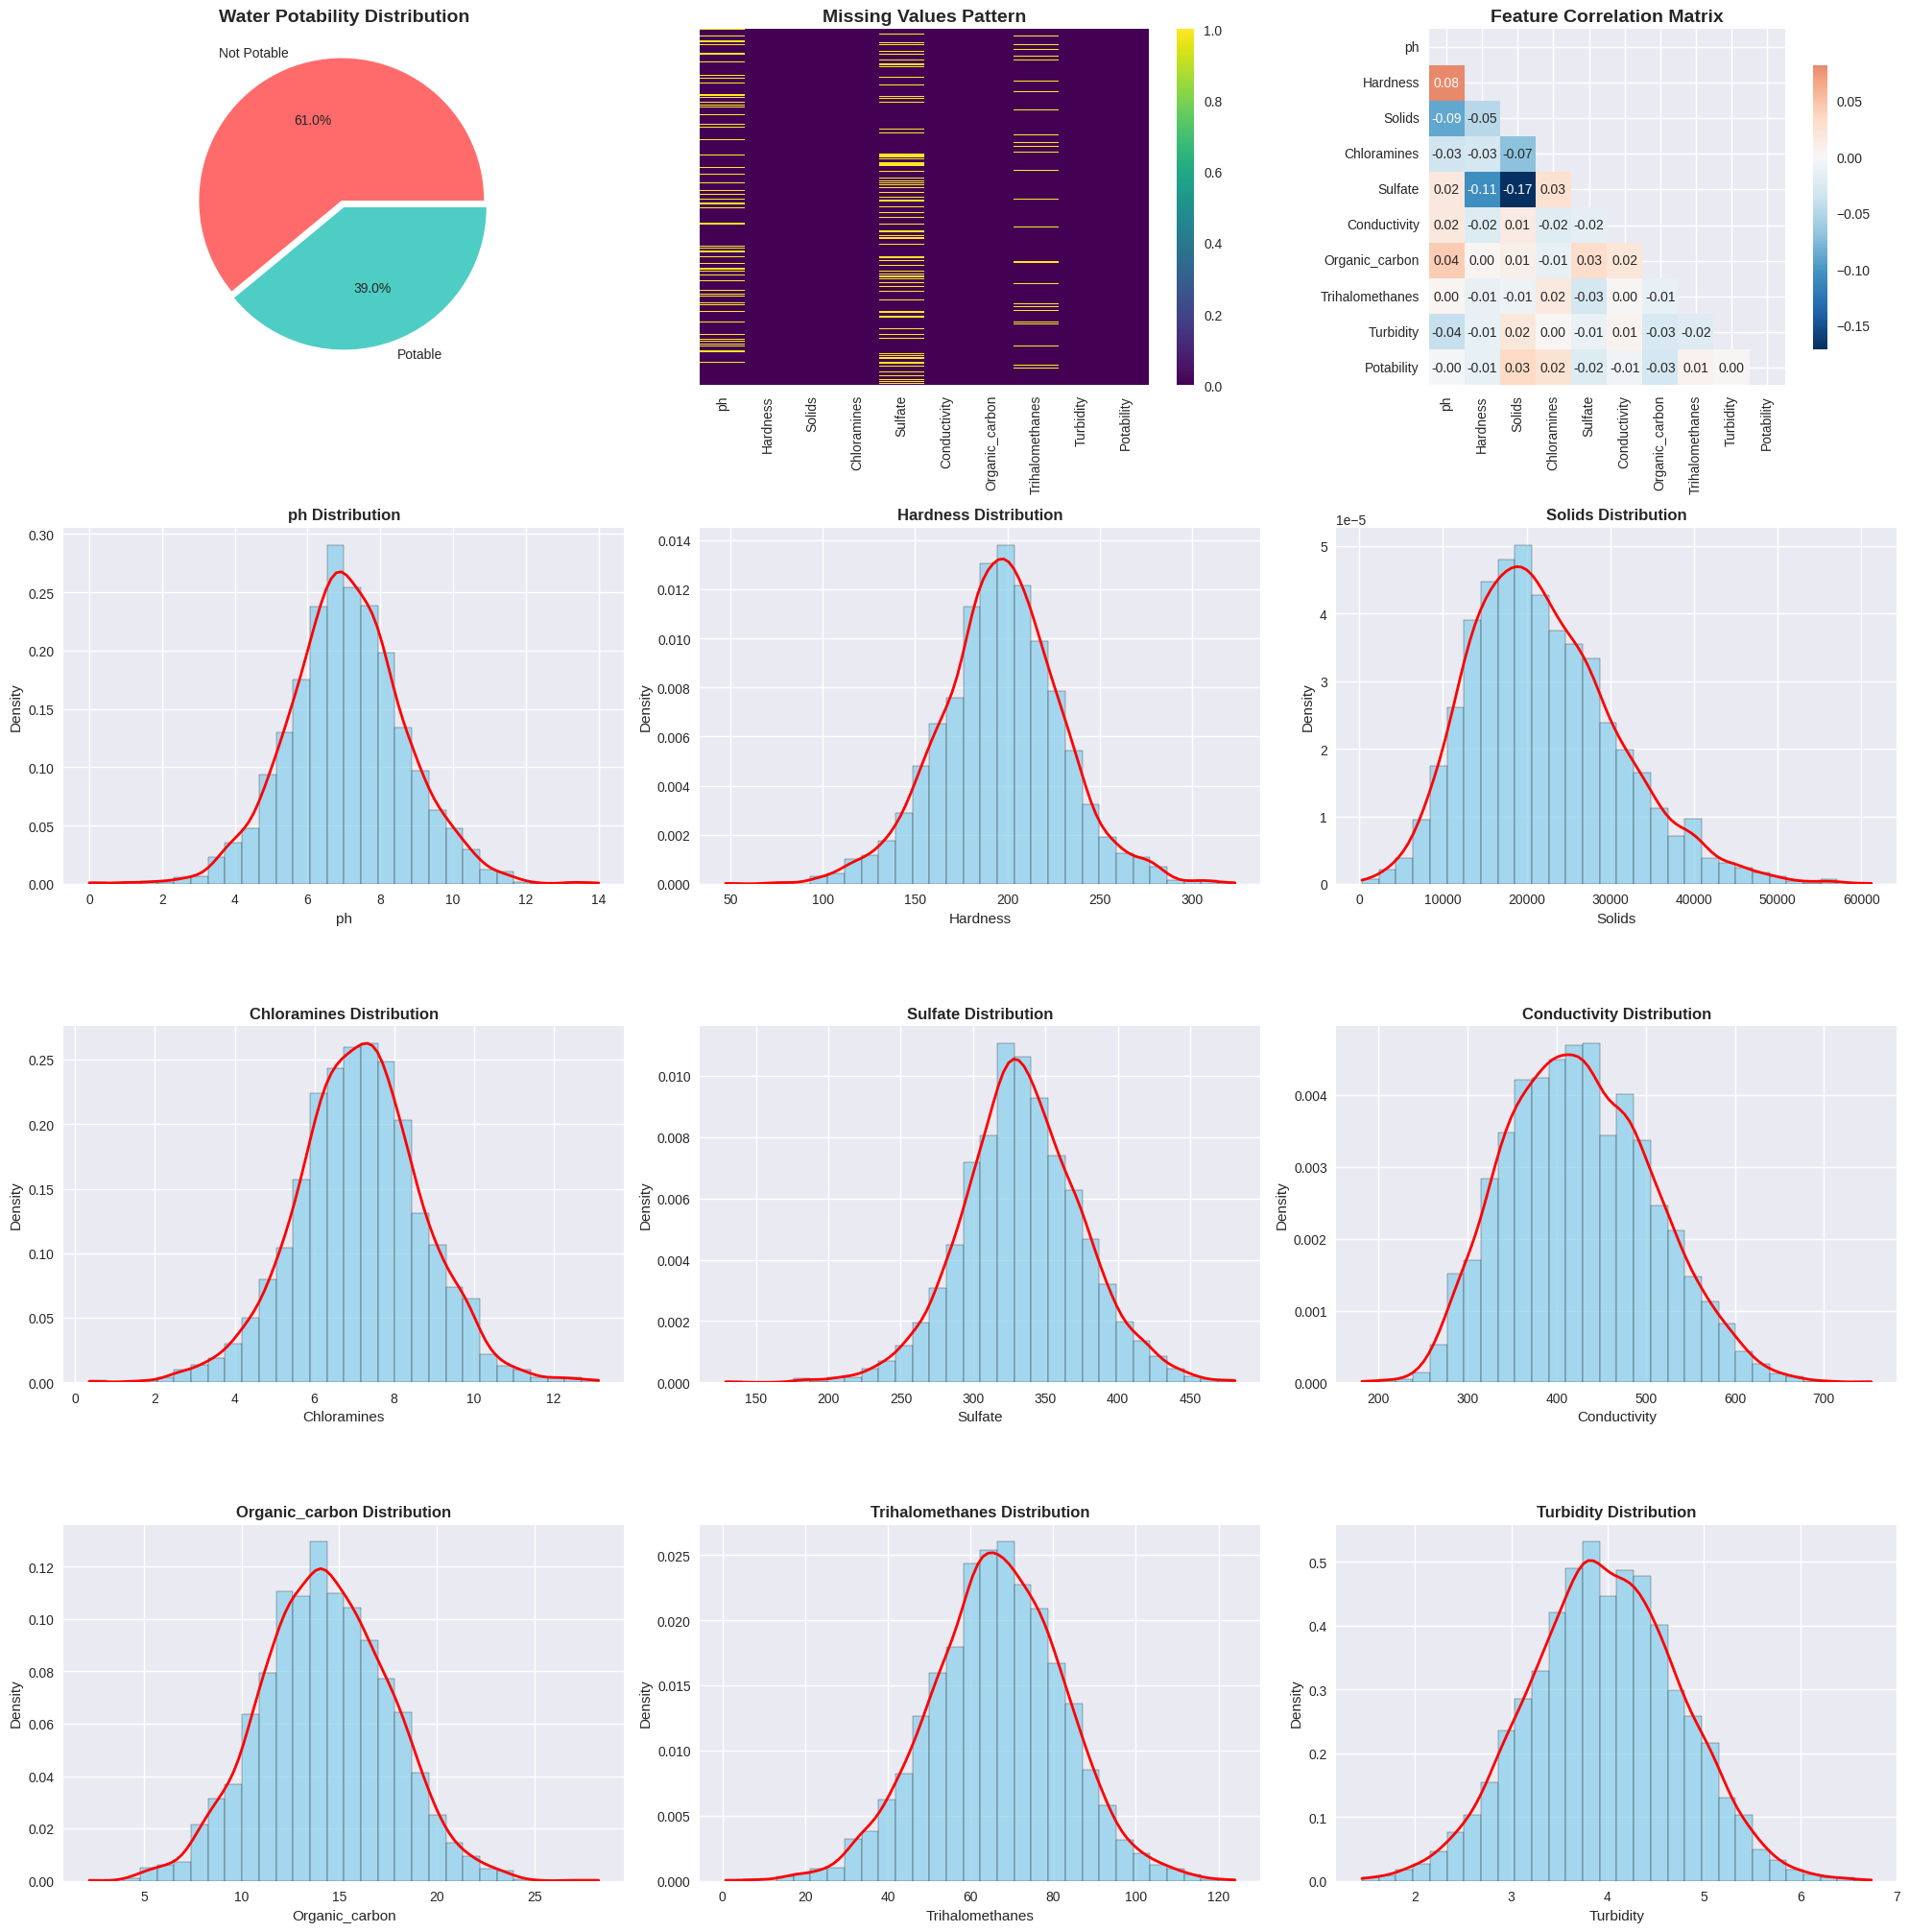

In [ ]:
fig = plt.figure(figsize=(20, 25))

# 1. Target distribution
plt.subplot(5, 3, 1)
colors = ['#FF6B6B', '#4ECDC4']
wedges, texts, autotexts = plt.pie(target_counts.values,
                                  labels=['Not Potable', 'Potable'],
                                  autopct='%1.1f%%',
                                  colors=colors,
                                  explode=(0.05, 0))
plt.title('Water Potability Distribution', fontsize=14, fontweight='bold')

# 2. Missing values heatmap
plt.subplot(5, 3, 2)
missing_data = df.isnull()
sns.heatmap(missing_data, cbar=True, yticklabels=False, cmap='viridis')
plt.title('Missing Values Pattern', fontsize=14, fontweight='bold')

# 3. Correlation heatmap
plt.subplot(5, 3, 3)
correlation_matrix = df.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='RdBu_r', center=0,
            square=True, fmt='.2f', cbar_kws={"shrink": .8})
plt.title('Feature Correlation Matrix', fontsize=14, fontweight='bold')

# 4-12. Distribution plots for each feature
features = df.columns[:-1]
for i, feature in enumerate(features, 4):
    plt.subplot(5, 3, i)

    # Histogram with KDE
    plt.hist(df[feature].dropna(), bins=30, alpha=0.7, density=True, color='skyblue', edgecolor='black')

    # Add KDE line
    data_clean = df[feature].dropna()
    if len(data_clean) > 0:
        from scipy.stats import gaussian_kde
        kde = gaussian_kde(data_clean)
        x_range = np.linspace(data_clean.min(), data_clean.max(), 100)
        plt.plot(x_range, kde(x_range), 'r-', linewidth=2)

    plt.title(f'{feature} Distribution', fontsize=12, fontweight='bold')
    plt.xlabel(feature)
    plt.ylabel('Density')

plt.tight_layout()
plt.show()

Analysis:

1. Missing Values Pattern: The heatmap highlights that some features have more missing values than others, indicated by yellow lines. This uneven distribution of missing data can affect model reliability. So, in the next processing step, we will address the missing values.

2. The correlation matrix reveals relationships between water quality parameters. Hardness and solids show a moderate positive correlation (0.08), suggesting higher mineral content may coincide with more solids. Chloramines have slight negative correlations with several features, indicating possible inverse relationships. These insights can guide feature selection for modeling in the next step.

3. The feature distributions show that most water samples have neutral pH (~7), moderate hardness, and low levels of chloramines, organic carbon, and turbidity, indicating generally clean and well-treated water. Solids and conductivity show more variability, with some high-value outliers. Sulfate and trihalomethanes are consistently distributed around central values, suggesting stable concentrations across samples.

## Statistical Testing and Analysis

In [ ]:
# Normality tests
print("\n NORMALITY TESTS (Shapiro-Wilk):")
print("-" * 40)
normality_results = {}
for feature in features:
    data_clean = df[feature].dropna()
    if len(data_clean) > 3:
        sample_data = data_clean.sample(min(5000, len(data_clean)), random_state=42)
        stat, p_value = shapiro(sample_data)
        is_normal = p_value > 0.05
        normality_results[feature] = {'statistic': stat, 'p_value': p_value, 'is_normal': is_normal}
        print(f"{feature:15s}: p-value = {p_value:.6f} {'✓ Normal' if is_normal else '✗ Not Normal'}")

# Statistical tests between potable and non-potable water
print(f"\n STATISTICAL DIFFERENCES BETWEEN GROUPS:")
print("-" * 40)
statistical_results = {}

for feature in features:
    potable_data = df[df['Potability'] == 1][feature].dropna()
    non_potable_data = df[df['Potability'] == 0][feature].dropna()

    if len(potable_data) > 0 and len(non_potable_data) > 0:
        # Use Mann-Whitney U test (non-parametric)
        stat, p_value = mannwhitneyu(potable_data, non_potable_data, alternative='two-sided')
        effect_size = (np.mean(potable_data) - np.mean(non_potable_data)) / np.sqrt(
            (np.var(potable_data) + np.var(non_potable_data)) / 2)

        statistical_results[feature] = {
            'statistic': stat,
            'p_value': p_value,
            'significant': p_value < 0.05,
            'effect_size': effect_size
        }

        significance = "✓ Significant" if p_value < 0.05 else "✗ Not Significant"
        print(f"{feature:15s}: p-value = {p_value:.6f} {significance} (Effect size: {effect_size:.3f})")

# Feature importance using correlation
print(f"\n FEATURE IMPORTANCE (Correlation with Target):")
print("-" * 40)
feature_importance = df.corr()['Potability'].abs().sort_values(ascending=False)[1:]
for feature, importance in feature_importance.items():
    print(f"{feature:15s}: {importance:.4f}")


 NORMALITY TESTS (Shapiro-Wilk):
----------------------------------------
ph             : p-value = 0.000001 ✗ Not Normal
Hardness       : p-value = 0.000000 ✗ Not Normal
Solids         : p-value = 0.000000 ✗ Not Normal
Chloramines    : p-value = 0.000002 ✗ Not Normal
Sulfate        : p-value = 0.000003 ✗ Not Normal
Conductivity   : p-value = 0.000000 ✗ Not Normal
Organic_carbon : p-value = 0.625125 ✓ Normal
Trihalomethanes: p-value = 0.034790 ✗ Not Normal
Turbidity      : p-value = 0.933579 ✓ Normal

 STATISTICAL DIFFERENCES BETWEEN GROUPS:
----------------------------------------
ph             : p-value = 0.908386 ✗ Not Significant (Effect size: -0.007)
Hardness       : p-value = 0.543907 ✗ Not Significant (Effect size: -0.028)
Solids         : p-value = 0.133284 ✗ Not Significant (Effect size: 0.069)
Chloramines    : p-value = 0.152856 ✗ Not Significant (Effect size: 0.048)
Sulfate        : p-value = 0.404974 ✗ Not Significant (Effect size: -0.047)
Conductivity   : p-value = 0.55

Analysis:

1. Most features do not follow a normal distribution, so statistical tests that assume normality (like t-tests) are not appropriate here. It's correct that we used non-parametric tests (like the Mann-Whitney U test) in the next step.

2. Statistically, there are no strong individual features that distinguish potable from non-potable water. This suggests that potability is likely influenced by complex combinations of features, rather than any single one.

3. All features have very weak linear correlation with Potability. This means no single feature has strong predictive power on its own, at least not in a linear sense.



## Feature Engineering

In [ ]:
df_engineered = df.copy()

### Handle missing values

In [ ]:
missing_strategies = {
    'ph': df_engineered['ph'].median(),  # pH is typically around 7
    'Hardness': df_engineered['Hardness'].mean(),  # Use mean for hardness
    'Solids': df_engineered['Solids'].median(),  # Use median for solids
    'Chloramines': df_engineered['Chloramines'].mean(),  # Use mean for chloramines
    'Sulfate': df_engineered['Sulfate'].median(),  # Use median for sulfate
    'Conductivity': df_engineered['Conductivity'].mean(),  # Use mean for conductivity
    'Organic_carbon': df_engineered['Organic_carbon'].median(),  # Use median
    'Trihalomethanes': df_engineered['Trihalomethanes'].mean(),  # Use mean
    'Turbidity': df_engineered['Turbidity'].median()  # Use median for turbidity
}

for column, fill_value in missing_strategies.items():
    if column in df_engineered.columns:
        before_count = df_engineered[column].isnull().sum()
        df_engineered[column].fillna(fill_value, inplace=True)
        after_count = df_engineered[column].isnull().sum()
        print(f"{column:15s}: {before_count:4d} → {after_count:4d} missing values")


ph             :  491 →    0 missing values
Hardness       :    0 →    0 missing values
Solids         :    0 →    0 missing values
Chloramines    :    0 →    0 missing values
Sulfate        :  781 →    0 missing values
Conductivity   :    0 →    0 missing values
Organic_carbon :    0 →    0 missing values
Trihalomethanes:  162 →    0 missing values
Turbidity      :    0 →    0 missing values


### Feature creation

In [ ]:
# pH-based features
df_engineered['ph_category'] = pd.cut(df_engineered['ph'],
                                    bins=[0, 6.5, 8.5, 14],
                                    labels=['Acidic', 'Neutral', 'Basic'])
df_engineered['ph_acidic'] = (df_engineered['ph'] < 6.5).astype(int)
df_engineered['ph_basic'] = (df_engineered['ph'] > 8.5).astype(int)
df_engineered['ph_optimal'] = ((df_engineered['ph'] >= 6.5) & (df_engineered['ph'] <= 8.5)).astype(int)

# Hardness categories (WHO standards)
df_engineered['hardness_category'] = pd.cut(df_engineered['Hardness'],
                                          bins=[0, 60, 120, 180, float('inf')],
                                          labels=['Soft', 'Moderately_hard', 'Hard', 'Very_hard'])
df_engineered['hardness_soft'] = (df_engineered['Hardness'] < 60).astype(int)
df_engineered['hardness_very_hard'] = (df_engineered['Hardness'] > 180).astype(int)

# TDS (Total Dissolved Solids) categories
df_engineered['tds_category'] = pd.cut(df_engineered['Solids'],
                                     bins=[0, 300, 600, 900, float('inf')],
                                     labels=['Excellent', 'Good', 'Fair', 'Poor'])
df_engineered['tds_excellent'] = (df_engineered['Solids'] < 300).astype(int)
df_engineered['tds_poor'] = (df_engineered['Solids'] > 900).astype(int)

# Chemical ratios and interactions
df_engineered['chloramine_sulfate_ratio'] = df_engineered['Chloramines'] / (df_engineered['Sulfate'] + 1e-6)
df_engineered['organic_carbon_ratio'] = df_engineered['Organic_carbon'] / (df_engineered['Solids'] + 1e-6)
df_engineered['conductivity_solids_ratio'] = df_engineered['Conductivity'] / (df_engineered['Solids'] + 1e-6)
df_engineered['trihalomethanes_chloramines_ratio'] = df_engineered['Trihalomethanes'] / (df_engineered['Chloramines'] + 1e-6)

# Polynomial features for important variables
df_engineered['ph_squared'] = df_engineered['ph'] ** 2
df_engineered['hardness_squared'] = df_engineered['Hardness'] ** 2
df_engineered['solids_squared'] = df_engineered['Solids'] ** 2
df_engineered['turbidity_squared'] = df_engineered['Turbidity'] ** 2


In [ ]:
# Log transformations for skewed features
skewed_features = ['Solids', 'Chloramines', 'Sulfate', 'Organic_carbon', 'Trihalomethanes', 'Turbidity']
for feature in skewed_features:
    if feature in df_engineered.columns:
        df_engineered[f'{feature}_log'] = np.log1p(df_engineered[feature])

# Interaction terms
df_engineered['ph_hardness_interaction'] = df_engineered['ph'] * df_engineered['Hardness']
df_engineered['chloramines_turbidity_interaction'] = df_engineered['Chloramines'] * df_engineered['Turbidity']
df_engineered['conductivity_solids_interaction'] = df_engineered['Conductivity'] * df_engineered['Solids']

# Water quality index (simplified)
df_engineered['water_quality_index'] = (
    df_engineered['ph_optimal'] * 0.2 +
    df_engineered['hardness_soft'] * 0.15 +
    df_engineered['tds_excellent'] * 0.2 +
    (1 - df_engineered['Turbidity'] / df_engineered['Turbidity'].max()) * 0.15 +
    (1 - df_engineered['Organic_carbon'] / df_engineered['Organic_carbon'].max()) * 0.15 +
    (1 - df_engineered['Trihalomethanes'] / df_engineered['Trihalomethanes'].max()) * 0.15
)

# Encode categorical features
categorical_features = ['ph_category', 'hardness_category', 'tds_category']
for feature in categorical_features:
    if feature in df_engineered.columns:
        dummies = pd.get_dummies(df_engineered[feature], prefix=feature)
        df_engineered = pd.concat([df_engineered, dummies], axis=1)
        df_engineered.drop(feature, axis=1, inplace=True)

In [ ]:
print(f" Feature engineering complete!")
print(f" Original features: {df.shape[1]}")
print(f" Engineered features: {df_engineered.shape[1]}")
print(f" New features created: {df_engineered.shape[1] - df.shape[1]}")

 Feature engineering complete!
 Original features: 10
 Engineered features: 46
 New features created: 36


### Feature Selection and Dimensionality Reduction

In [ ]:
X_all = df_engineered.drop('Potability', axis=1)
y = df_engineered['Potability']

# Remove infinite and NaN values
X_all = X_all.replace([np.inf, -np.inf], np.nan)
X_all = X_all.fillna(X_all.median())

print(f"Total features available: {X_all.shape[1]}")

Total features available: 45


### Mutiple methods to feature selection

In [ ]:
# Method 1: Statistical Feature Selection (SelectKBest)
print(f"METHOD 1: Statistical Feature Selection")
selector_stats = SelectKBest(score_func=f_classif, k=20)
X_stats = selector_stats.fit_transform(X_all, y)
selected_features_stats = X_all.columns[selector_stats.get_support()]
feature_scores = selector_stats.scores_[selector_stats.get_support()]

print("Top 20 Statistical Features:")
for feature, score in zip(selected_features_stats, feature_scores):
    print(f"{feature:30s}: {score:.2f}")

# Method 2: Tree-based Feature Selection
print(f"\n METHOD 2: Tree-based Feature Selection")
rf_selector = RandomForestClassifier(n_estimators=100, random_state=42)
rf_selector.fit(X_all, y)
feature_importance_rf = pd.DataFrame({
    'feature': X_all.columns,
    'importance': rf_selector.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 20 Tree-based Features:")
for _, row in feature_importance_rf.head(20).iterrows():
    print(f"{row['feature']:30s}: {row['importance']:.4f}")

# Method 3: L1 Regularization (Lasso)
print(f"\n METHOD 3: L1 Regularization Feature Selection")
scaler_temp = StandardScaler()
X_scaled_temp = scaler_temp.fit_transform(X_all)
lasso_selector = SelectFromModel(Lasso(alpha=0.01, random_state=42))
X_lasso = lasso_selector.fit_transform(X_scaled_temp, y)
selected_features_lasso = X_all.columns[lasso_selector.get_support()]

print(f"L1 Regularization selected {len(selected_features_lasso)} features:")
for feature in selected_features_lasso:
    print(f"  - {feature}")

# Method 4: Recursive Feature Elimination
print(f"\n METHOD 4: Recursive Feature Elimination")
estimator = LogisticRegression(random_state=42, max_iter=1000)
rfe_selector = RFE(estimator, n_features_to_select=15)
X_rfe = rfe_selector.fit_transform(X_scaled_temp, y)
selected_features_rfe = X_all.columns[rfe_selector.get_support()]

print(f"RFE selected {len(selected_features_rfe)} features:")
for feature in selected_features_rfe:
    print(f"  - {feature}")


METHOD 1: Statistical Feature Selection
Top 20 Statistical Features:
Solids                        : 3.73
Chloramines                   : 1.85
Organic_carbon                : 2.95
ph_acidic                     : 2.88
ph_basic                      : 8.38
ph_optimal                    : 13.24
hardness_very_hard            : 3.11
chloramine_sulfate_ratio      : 5.48
trihalomethanes_chloramines_ratio: 2.12
solids_squared                : 5.22
Sulfate_log                   : 4.27
Organic_carbon_log            : 2.63
ph_hardness_interaction       : 1.83
conductivity_solids_interaction: 3.04
water_quality_index           : 13.75
ph_category_Acidic            : 2.78
ph_category_Neutral           : 13.24
ph_category_Basic             : 8.38
hardness_category_Moderately_hard: 3.12
hardness_category_Very_hard   : 3.11

 METHOD 2: Tree-based Feature Selection
Top 20 Tree-based Features:
Sulfate                       : 0.0480
Sulfate_log                   : 0.0465
hardness_squared              : 0.

In [ ]:
# Combine feature selection methods
print(f"FEATURE SELECTION ENSEMBLE:")
all_selected_features = set()
all_selected_features.update(selected_features_stats[:15])
all_selected_features.update(feature_importance_rf.head(15)['feature'])
all_selected_features.update(selected_features_lasso)
all_selected_features.update(selected_features_rfe)

final_selected_features = list(all_selected_features)
print(f"Total unique features selected: {len(final_selected_features)}")


FEATURE SELECTION ENSEMBLE:
Total unique features selected: 32


In [ ]:
# Create different feature sets
feature_sets = {
    'original': df.columns[:-1].tolist(),
    'statistical_top20': selected_features_stats.tolist(),
    'tree_based_top20': feature_importance_rf.head(20)['feature'].tolist(),
    'lasso_selected': selected_features_lasso.tolist(),
    'rfe_selected': selected_features_rfe.tolist(),
    'ensemble_selected': final_selected_features
}

print(f"FEATURE SETS CREATED:")
for name, features in feature_sets.items():
    print(f"{name:20s}: {len(features)} features")

FEATURE SETS CREATED:
original            : 9 features
statistical_top20   : 20 features
tree_based_top20    : 20 features
lasso_selected      : 12 features
rfe_selected        : 15 features
ensemble_selected   : 32 features


In [ ]:
selected_df = pd.DataFrame({'Selected Features': final_selected_features})
selected_df

,Selected Features
0,chloramine_sulfate_ratio
1,Solids_log
2,Chloramines
3,ph_optimal
4,Organic_carbon_log
5,ph_acidic
6,Organic_carbon
7,conductivity_solids_interaction
8,trihalomethanes_chloramines_ratio
9,ph_hardness_interaction


## Data Preprocessing

In [ ]:
preprocessing_results = {}

for set_name, selected_features in feature_sets.items():
    print(f"\n Processing feature set: {set_name}")
    print("-" * 40)

    # Select features
    if set_name == 'original':
        X_selected = df[selected_features].copy()
        y_selected = df['Potability'].copy()
    else:
        X_selected = df_engineered[selected_features].copy()
        y_selected = df_engineered['Potability'].copy()

    # Handle missing/infinite values
    X_selected = X_selected.fillna(X_selected.median())
    X_selected = X_selected.replace([np.inf, -np.inf], np.nan)
    X_selected = X_selected.fillna(X_selected.median())

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X_selected, y_selected,
        test_size=0.2, random_state=42,
        stratify=y_selected
    )

    # Scale the features
    scalers = {
        'standard': StandardScaler(),
        'robust':   RobustScaler(),
        'minmax':   MinMaxScaler()
    }
    scaled_data = {}
    for scaler_name, scaler in scalers.items():
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled  = scaler.transform(X_test)
        scaled_data[scaler_name] = {
            'X_train': X_train_scaled,
            'X_test':  X_test_scaled,
            'scaler':  scaler
        }
    preprocessing_results[set_name] = {
        'X_train':       X_train,
        'X_test':        X_test,
        'y_train':       y_train,
        'y_test':        y_test,
        'scaled_data':   scaled_data,
        'feature_names': selected_features
    }

    print(f" Training set: {X_train.shape}")
    print(f" Test set:     {X_test.shape}")
    print(f" Scalers:      {list(scalers.keys())}")


 Processing feature set: original
----------------------------------------
 Training set: (2620, 9)
 Test set:     (656, 9)
 Scalers:      ['standard', 'robust', 'minmax']

 Processing feature set: statistical_top20
----------------------------------------
 Training set: (2620, 20)
 Test set:     (656, 20)
 Scalers:      ['standard', 'robust', 'minmax']

 Processing feature set: tree_based_top20
----------------------------------------
 Training set: (2620, 20)
 Test set:     (656, 20)
 Scalers:      ['standard', 'robust', 'minmax']

 Processing feature set: lasso_selected
----------------------------------------
 Training set: (2620, 12)
 Test set:     (656, 12)
 Scalers:      ['standard', 'robust', 'minmax']

 Processing feature set: rfe_selected
----------------------------------------
 Training set: (2620, 15)
 Test set:     (656, 15)
 Scalers:      ['standard', 'robust', 'minmax']

 Processing feature set: ensemble_selected
----------------------------------------
 Training set: 

## Machine Learning Models

In [ ]:
# 1. Grid search object for LightGBM
lgb_grid = GridSearchCV(
    # LGBMClassifier(device='gpu', gpu_platform_id=0, gpu_device_id=0, random_state=42, verbosity=-1),
    LGBMClassifier(random_state=42, verbosity=-1),
    param_grid={
        'n_estimators': [100, 200, 300],
        'num_leaves': [31, 64],
        'learning_rate': [0.05, 0.1],
        'max_depth': [5, 7],
        'min_child_samples': [10, 20]
    },
    scoring='f1',
    cv=3,
    n_jobs=-1
)

# 2. Grid search object for XGBoost
xgb_grid = GridSearchCV(
    # XGBClassifier(tree_method='gpu_hist', predictor='gpu_predictor', gpu_id=0, eval_metric='logloss', random_state=42),
    XGBClassifier(eval_metric='logloss', random_state=42),
    param_grid={
        'n_estimators': [100, 200],
        'max_depth': [3, 5],
        'learning_rate': [0.05, 0.1]
    },
    scoring='f1',
    cv=3,
    n_jobs=-1
)

# 3. Basic Random Forest classifier
rf_clf = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=42)

In [ ]:
def evaluate_final_model(model, X_test, y_test):

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None

    # Calculate standard evaluation metrics
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1_score': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None
    }
    return metrics

In [ ]:
all_results = {}
smote = SMOTE(random_state=42)

# loop over each preprocessed dataset
for dataset_name, data in preprocessing_results.items():
    print(f"\n Processing dataset: {dataset_name}")

    # 1. Apply SMOTE oversampling to the training set
    X_resampled, y_resampled = smote.fit_resample(data['X_train'], data['y_train'])

    dataset_results = {}

    # 2. Loop over each scaler
    for scaler_name, scaler in scalers.items():
        print(f"\n--- Using scaler: {scaler_name} ---")
        X_train_scaled = scaler.fit_transform(X_resampled)
        X_test_scaled = scaler.transform(data['X_test'])
        y_test = data['y_test']

        # 3. Hyperparameter tuning
        print("Tuning LightGBM...")
        lgb_grid.fit(X_train_scaled, y_resampled)
        best_lgb = lgb_grid.best_estimator_

        print("Tuning XGBoost...")
        xgb_grid.fit(X_train_scaled, y_resampled)
        best_xgb = xgb_grid.best_estimator_

        print("Training RandomForest...")
        rf_clf.fit(X_train_scaled, y_resampled)

        # 4) Create and train Voting Ensemble
        print("Building Voting Classifier...")
        voting_clf = VotingClassifier(
            estimators=[
                ('xgb', best_xgb),
                ('lgb', best_lgb),
                ('rf', rf_clf)
            ],
            voting='soft',
            n_jobs=-1
        )
        voting_clf.fit(X_train_scaled, y_resampled)

        # 5. Evaluate all models on the test set
        print("\n--- Final Test Set Evaluation ---")
        models_to_evaluate = {
            'XGBoost (tuned)': best_xgb,
            'LightGBM (tuned)': best_lgb,
            'RandomForest': rf_clf,
            'Voting Ensemble': voting_clf
        }

        scaler_results = {}
        for model_name, model in models_to_evaluate.items():
            metrics = evaluate_final_model(model, X_test_scaled, y_test)
            scaler_results[model_name] = metrics
            auc_str = f"{metrics['roc_auc']:.4f}" if metrics['roc_auc'] is not None else "N/A"
            print(
                f"{model_name:25}: "
                f"Acc={metrics['accuracy']:.4f}, "
                f"F1={metrics['f1_score']:.4f}, "
                f"AUC={auc_str}"
            )

        dataset_results[scaler_name] = scaler_results
    all_results[dataset_name] = dataset_results


 Processing dataset: original

--- Using scaler: standard ---
Tuning LightGBM...
Tuning XGBoost...
Training RandomForest...
Building Voting Classifier...

--- Final Test Set Evaluation ---
XGBoost (tuned)          : Acc=0.6341, F1=0.5367, AUC=0.6478
LightGBM (tuned)         : Acc=0.6463, F1=0.5397, AUC=0.6482
RandomForest             : Acc=0.6509, F1=0.5278, AUC=0.6709
Voting Ensemble          : Acc=0.6509, F1=0.5374, AUC=0.6601

--- Using scaler: robust ---
Tuning LightGBM...
Tuning XGBoost...
Training RandomForest...
Building Voting Classifier...

--- Final Test Set Evaluation ---
XGBoost (tuned)          : Acc=0.6341, F1=0.5367, AUC=0.6478
LightGBM (tuned)         : Acc=0.6250, F1=0.5040, AUC=0.6450
RandomForest             : Acc=0.6509, F1=0.5278, AUC=0.6709
Voting Ensemble          : Acc=0.6387, F1=0.5288, AUC=0.6595

--- Using scaler: minmax ---
Tuning LightGBM...
Tuning XGBoost...
Training RandomForest...
Building Voting Classifier...

--- Final Test Set Evaluation ---
XGBoost 

## Model Performance Analysis

In [ ]:
performance_data = []

for set_name, set_results in all_results.items():
    for scaler_name, scaler_results in set_results.items():
        for model_name, result in scaler_results.items():
            performance_data.append({
                'feature_set': set_name,
                'scaler': scaler_name,
                'model': model_name,
                'accuracy': result['accuracy'],
                'precision': result['precision'],
                'recall': result['recall'],
                'f1_score': result['f1_score'],
                'roc_auc': result['roc_auc'],
            })

In [ ]:
performance_df = pd.DataFrame(performance_data)

# Find best models
print("\n TOP 10 BEST PERFORMING MODELS (by Accuracy):")
print("-" * 60)
top_models = performance_df.nlargest(10, 'accuracy')
for idx, row in top_models.iterrows():
    print(f"{row['model']:20s} | {row['feature_set']:15s} | {row['scaler']:8s} | "
          f"Acc: {row['accuracy']:.4f} | F1: {row['f1_score']:.4f} | AUC: {row['roc_auc']:.4f}")

# Best model by different metrics
print(f"\n BEST MODELS BY DIFFERENT METRICS:")
print("-" * 40)
metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']
for metric in metrics:
    if metric in performance_df.columns:
        best_idx = performance_df[metric].idxmax()
        best_model = performance_df.loc[best_idx]
        print(f"{metric.upper():12s}: {best_model['model']} "
              f"({best_model['feature_set']}, {best_model['scaler']}) = {best_model[metric]:.4f}")



 TOP 10 BEST PERFORMING MODELS (by Accuracy):
------------------------------------------------------------
RandomForest         | ensemble_selected | minmax   | Acc: 0.6768 | F1: 0.5330 | AUC: 0.6716
RandomForest         | rfe_selected    | standard | Acc: 0.6738 | F1: 0.5720 | AUC: 0.7056
RandomForest         | rfe_selected    | robust   | Acc: 0.6738 | F1: 0.5720 | AUC: 0.7056
RandomForest         | rfe_selected    | minmax   | Acc: 0.6738 | F1: 0.5720 | AUC: 0.7056
XGBoost (tuned)      | rfe_selected    | minmax   | Acc: 0.6677 | F1: 0.5692 | AUC: 0.6925
RandomForest         | ensemble_selected | standard | Acc: 0.6677 | F1: 0.5219 | AUC: 0.6707
RandomForest         | ensemble_selected | robust   | Acc: 0.6677 | F1: 0.5219 | AUC: 0.6707
Voting Ensemble      | rfe_selected    | standard | Acc: 0.6585 | F1: 0.5520 | AUC: 0.6965
Voting Ensemble      | rfe_selected    | minmax   | Acc: 0.6585 | F1: 0.5591 | AUC: 0.6932
RandomForest         | original        | standard | Acc: 0.6509 | F

## Performance visualization

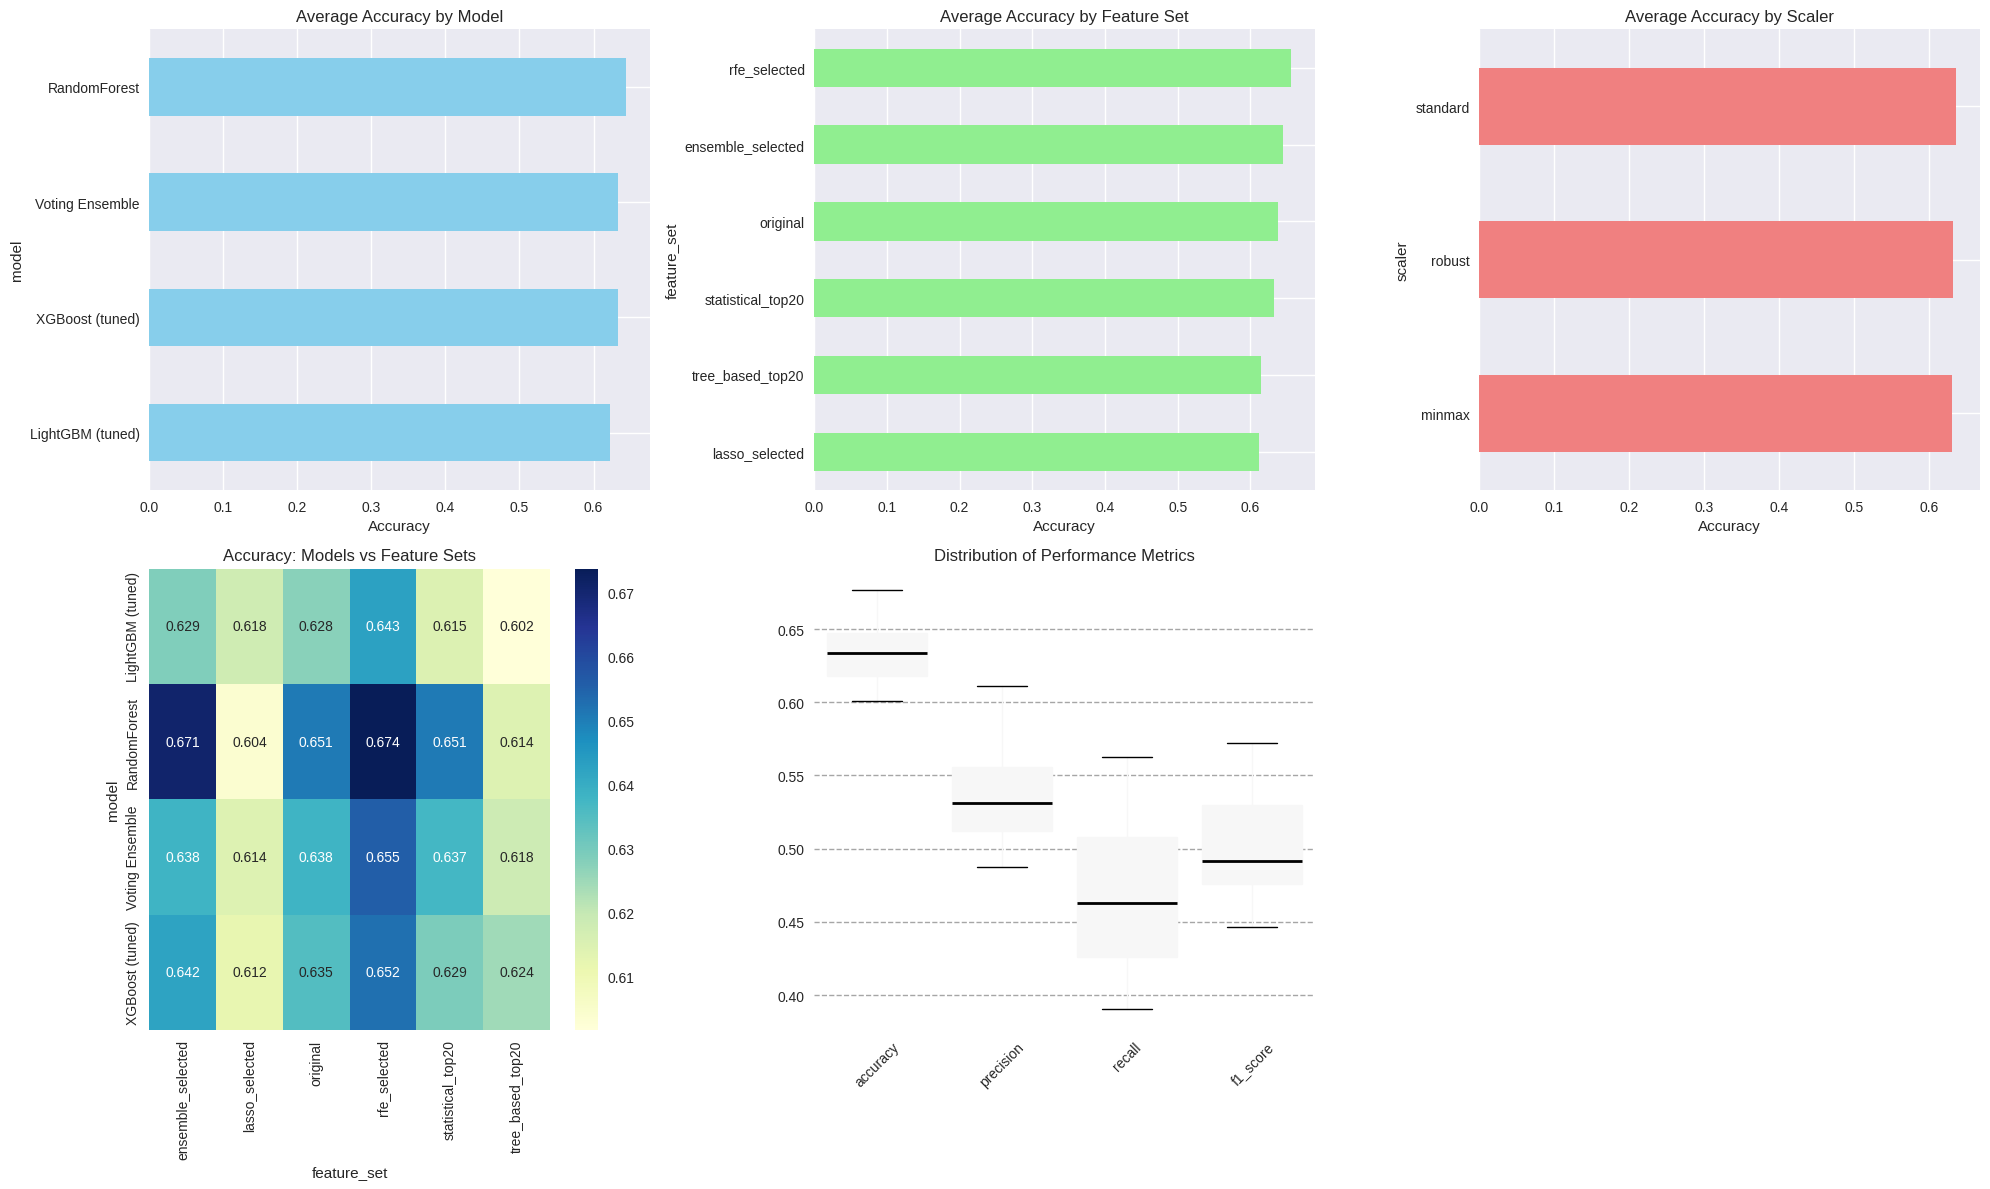

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# 1. Model comparison (average across all feature sets and scalers)
model_avg = performance_df.groupby('model')[['accuracy', 'f1_score', 'roc_auc']].mean().sort_values('accuracy', ascending=True)
model_avg['accuracy'].plot(kind='barh', ax=axes[0, 0], color='skyblue')
axes[0, 0].set_title('Average Accuracy by Model')
axes[0, 0].set_xlabel('Accuracy')

# 2. Feature set comparison
feature_avg = performance_df.groupby('feature_set')[['accuracy', 'f1_score', 'roc_auc']].mean().sort_values('accuracy', ascending=True)
feature_avg['accuracy'].plot(kind='barh', ax=axes[0, 1], color='lightgreen')
axes[0, 1].set_title('Average Accuracy by Feature Set')
axes[0, 1].set_xlabel('Accuracy')

# 3. Scaler comparison
scaler_avg = performance_df.groupby('scaler')[['accuracy', 'f1_score', 'roc_auc']].mean().sort_values('accuracy', ascending=True)
scaler_avg['accuracy'].plot(kind='barh', ax=axes[0, 2], color='lightcoral')
axes[0, 2].set_title('Average Accuracy by Scaler')
axes[0, 2].set_xlabel('Accuracy')

# 4. Heatmap of model performance
pivot_table = performance_df.pivot_table(values='accuracy', index='model', columns='feature_set', aggfunc='mean')
sns.heatmap(pivot_table, annot=True, cmap='YlGnBu', ax=axes[1, 0], fmt='.3f')
axes[1, 0].set_title('Accuracy: Models vs Feature Sets')

# 5. Distribution of performance metrics
performance_df[['accuracy', 'precision', 'recall', 'f1_score']].boxplot(
    ax=axes[1, 1],
    patch_artist=True,
    medianprops=dict(color='black', linewidth=2),
    widths=0.8
)
axes[1, 1].set_title('Distribution of Performance Metrics')
axes[1, 1].grid(True, axis='y', linestyle='--', color='gray', alpha=0.7)
colors = ['skyblue', 'lightgreen', 'lightcoral', 'lightgoldenrodyellow']
for i, patch in enumerate(axes[1, 1].artists):
    patch.set_facecolor(colors[i])
axes[1, 1].set_facecolor('white')
axes[1, 1].tick_params(axis='x', rotation=45)

# Remove unused subplot
fig.delaxes(axes[1, 2])

plt.tight_layout()
plt.show()


Analysis:

1. Tree-based models like RandomForest and XGBoost are generally effective for this water quality dataset. RandomForest appears most robust across different feature sets and preprocessing.

2. RFE-selected features had the highest average accuracy, suggesting that Recursive Feature Elimination effectively selected informative variables.

3. Standard scaling showed the best performance.

4. The highest accuracy is 0.674, achieved by RandomForest with RFE-selected features.


## Hyperparameter Optimization

In [ ]:
# Select best performing combinations for hyperparameter tuning
best_combinations = performance_df.nlargest(5, 'accuracy')
print("Optimizing hyperparameters for top 5 models:")
for idx, row in best_combinations.iterrows():
    print(f"  - {row['model']} with {row['feature_set']} features and {row['scaler']} scaling")


Optimizing hyperparameters for top 5 models:
  - RandomForest with ensemble_selected features and minmax scaling
  - RandomForest with rfe_selected features and standard scaling
  - RandomForest with rfe_selected features and robust scaling
  - RandomForest with rfe_selected features and minmax scaling
  - XGBoost (tuned) with rfe_selected features and minmax scaling


In [ ]:
# param_grids = {
#     'RandomForest': {
#         'n_estimators': [100, 200, 300],
#         'max_depth': [None, 10, 20, 30],
#         'min_samples_split': [2, 5, 10],
#         'min_samples_leaf': [1, 2, 4],
#         'bootstrap': [True, False]
#     },
#     'XGBoost': {
#         'n_estimators': [100, 200],
#         'max_depth': [3, 6],
#         'learning_rate': [0.05, 0.1],
#         'subsample': [0.8, 1.0],
#         'colsample_bytree': [0.8, 1.0]
#     },
#     'Voting Ensemble': {
#         'voting': ['hard', 'soft'],
#         'weights': [None, [1, 1, 1], [2, 1, 1], [1, 2, 1], [1, 1, 2]],
#     }
# }

In [ ]:
param_grids = {
    'RandomForest': {
        'n_estimators': [100, 150],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 10],
        'min_samples_leaf': [1, 4],
        'bootstrap': [True]
    },
    'XGBoost': {
        'n_estimators': [100, 200],
        'max_depth': [3, 6],
        'learning_rate': [0.01, 0.05],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }
}

In [ ]:
# Perform hyperparameter optimization
optimized_models = {}

print("Performing hyperparameter optimization for top models...\n")

for idx, best_combo in best_combinations.iterrows():
    model_name = best_combo['model']
    feature_set = best_combo['feature_set']
    scaler_name = best_combo['scaler']

    # Only consider RandomForest and Voting Ensemble models
    if model_name in param_grids:
        print(f"Optimizing {model_name} | Features: {feature_set}, Scaler: {scaler_name}")

        # Get data
        data = preprocessing_results[feature_set]
        scaled_data = data['scaled_data'][scaler_name]
        X_train = scaled_data['X_train']
        X_test = scaled_data['X_test']
        y_train = data['y_train']
        y_test = data['y_test']

        # Get base model based on the model name
        if model_name == 'RandomForest':
            base_model = rf_clf
        elif 'XGBoost' in model_name:
            base_model = best_xgb
        # elif model_name == 'Voting Ensemble':
        #     # Create the voting ensemble with XGBoost, LightGBM, and RandomForest
        #     base_model = VotingClassifier(
        #         estimators=[
        #             ('xgb', best_xgb),
        #             ('lgb', best_lgb),
        #             ('rf', rf_clf)
        #         ],
        #         voting='soft',
        #         n_jobs=-1
        #     )

        # Calculate total combinations for progress estimation
        total_combinations = 1
        for param_values in param_grids[model_name].values():
            total_combinations *= len(param_values)

        print(f"   Total parameter combinations: {total_combinations}")
        print(f"   Total fits (with 5-fold CV): {total_combinations * 5}")

        # Grid search with cross-validation
        grid_search = GridSearchCV(
            base_model,
            param_grids[model_name],
            cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
            scoring='accuracy',
            n_jobs=-1,
            verbose=2
        )

        print(f"   Fitting grid search... (this may take several minutes)")
        import time
        start_time = time.time()
        grid_search.fit(X_train, y_train)
        end_time = time.time()
        print(f"   Grid search completed in {(end_time - start_time)/60:.1f} minutes")

        # Evaluate on test set
        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        # Handle probability prediction for different voting methods
        if hasattr(best_model, 'predict_proba'):
            try:
                y_pred_proba = best_model.predict_proba(X_test)[:, 1]
            except:
                # If predict_proba fails (e.g., with hard voting), use decision_function or set to None
                if hasattr(best_model, 'decision_function'):
                    decision_scores = best_model.decision_function(X_test)
                    # Convert decision scores to probabilities using sigmoid
                    from scipy.special import expit
                    y_pred_proba = expit(decision_scores)
                else:
                    y_pred_proba = None
        else:
            y_pred_proba = None

        # Calculate ROC AUC only if probabilities are available
        if y_pred_proba is not None:
            test_roc_auc = roc_auc_score(y_test, y_pred_proba)
        else:
            test_roc_auc = None

        # Store results
        optimized_models[f"{model_name}_{feature_set}_{scaler_name}"] = {
            'model': best_model,
            'best_params': grid_search.best_params_,
            'best_score': grid_search.best_score_,
            'test_accuracy': accuracy_score(y_test, y_pred),
            'test_f1': f1_score(y_test, y_pred),
            'test_roc_auc': test_roc_auc,
            'y_pred': y_pred,
            'y_pred_proba': y_pred_proba,
            'y_test': y_test,
            'feature_set': feature_set,
            'scaler': scaler_name
        }

        print(f"   Best CV Accuracy: {grid_search.best_score_:.4f}")
        print(f"   Test Accuracy: {accuracy_score(y_test, y_pred):.4f}")
        print(f"   Test F1: {f1_score(y_test, y_pred):.4f}")
        if test_roc_auc is not None:
            print(f"   Test ROC AUC: {test_roc_auc:.4f}")
        print(f"   Best Params: {grid_search.best_params_}\n")

print("Hyperparameter optimization completed!")
print(f"Total optimized models: {len(optimized_models)}")

# Display summary of optimized models
print("\n" + "="*60)
print("HYPERPARAMETER OPTIMIZATION SUMMARY")
print("="*60)

for key, results in optimized_models.items():
    print(f"\nModel: {key}")
    print(f"  Best CV Accuracy: {results['best_score']:.4f}")
    print(f"  Test Accuracy: {results['test_accuracy']:.4f}")
    print(f"  Test F1 Score: {results['test_f1']:.4f}")
    if results['test_roc_auc'] is not None:
        print(f"  Test ROC AUC: {results['test_roc_auc']:.4f}")
    print(f"  Best Parameters: {results['best_params']}")

Performing hyperparameter optimization for top models...

Optimizing RandomForest | Features: ensemble_selected, Scaler: minmax
   Total parameter combinations: 24
   Total fits (with 5-fold CV): 120
   Fitting grid search... (this may take several minutes)
Fitting 5 folds for each of 24 candidates, totalling 120 fits
   Grid search completed in 2.4 minutes
   Best CV Accuracy: 0.6805
   Test Accuracy: 0.6723
   Test F1: 0.4205
   Test ROC AUC: 0.6778
   Best Params: {'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 150}

Optimizing RandomForest | Features: rfe_selected, Scaler: standard
   Total parameter combinations: 24
   Total fits (with 5-fold CV): 120
   Fitting grid search... (this may take several minutes)
Fitting 5 folds for each of 24 candidates, totalling 120 fits
   Grid search completed in 1.8 minutes
   Best CV Accuracy: 0.6878
   Test Accuracy: 0.6845
   Test F1: 0.4706
   Test ROC AUC: 0.7016
   Best Params: {'bootstra

In [ ]:
print(f"OPTIMIZATION RESULTS:")
print("-" * 100)
print(f"{'Model':50s} {'Original Accuracy':15s} {'Optimized Accuracy':15s} {'Improvement':15s}")
print("-" * 100)

for key, opt_result in optimized_models.items():
    # Extract model name from key
    # parts = key.split('_')
    # model_name = parts[0]
    model_name = key

    feature_set = opt_result['feature_set']
    scaler = opt_result['scaler']

    # Create a mask to find the matching original accuracy score from performance_df
    mask = (
        (performance_df['model'] == model_name.split('_')[0]) &
        (performance_df['feature_set'] == feature_set) &
        (performance_df['scaler'] == scaler)
    )
    # Extract the matched original accuracy score
    matched = performance_df[mask]['accuracy'].values

    if len(matched) > 0:
        original_accuracy = matched[0]
        optimized_accuracy = opt_result['test_accuracy']
        improvement = optimized_accuracy - original_accuracy
        # print(f"{key[:24]:25s} {original_accuracy:11.4f} {optimized_accuracy:11.4f} {improvement:+11.4f}")
        print(f"{model_name:40s} {original_accuracy:17.4f} {optimized_accuracy:17.4f} {improvement:+18.4f}")


OPTIMIZATION RESULTS:
----------------------------------------------------------------------------------------------------
Model                                              Original Accuracy Optimized Accuracy Improvement    
----------------------------------------------------------------------------------------------------
RandomForest_ensemble_selected_minmax               0.6768            0.6723            -0.0046
RandomForest_rfe_selected_standard                  0.6738            0.6845            +0.0107
RandomForest_rfe_selected_robust                    0.6738            0.6845            +0.0107
RandomForest_rfe_selected_minmax                    0.6738            0.6845            +0.0107


Analysis:

1. Among all the tested combinations, the **RandomForest** model with **rfe_selected** features and hyperparameter tuning gives the **best accuracy (0.6845)**.

2. While the gain is modest, it still fulfills the goal of finding the best feature + model combination for water quality detection.

3. Further improvements could come from using more advanced models (like neural networks) or combining predictions (e.g., via voting ensembles).

## Deep Learning Model (FNN)

In [ ]:
def create_neural_network(input_dim, architecture='basic'):

    if architecture == 'basic':
        model = Sequential([
            Dense(64, activation='relu', input_shape=(input_dim,)),
            Dropout(0.3),
            Dense(32, activation='relu'),
            Dropout(0.3),
            Dense(16, activation='relu'),
            Dense(1, activation='sigmoid')
        ])

    elif architecture == 'deep':
        model = Sequential([
            Dense(128, activation='relu', input_shape=(input_dim,)),
            BatchNormalization(),
            Dropout(0.4),
            Dense(64, activation='relu'),
            BatchNormalization(),
            Dropout(0.4),
            Dense(32, activation='relu'),
            BatchNormalization(),
            Dropout(0.3),
            Dense(16, activation='relu'),
            Dropout(0.2),
            Dense(1, activation='sigmoid')
        ])

    elif architecture == 'wide':
        model = Sequential([
            Dense(256, activation='relu', input_shape=(input_dim,)),
            Dropout(0.5),
            Dense(128, activation='relu'),
            Dropout(0.4),
            Dense(64, activation='relu'),
            Dropout(0.3),
            Dense(1, activation='sigmoid')
        ])

    elif architecture == 'regularized':
        model = Sequential([
            Dense(100, activation='relu', input_shape=(input_dim,),
                  kernel_regularizer=tf.keras.regularizers.l2(0.001)),
            BatchNormalization(),
            Dropout(0.4),
            Dense(50, activation='relu',
                  kernel_regularizer=tf.keras.regularizers.l2(0.001)),
            BatchNormalization(),
            Dropout(0.3),
            Dense(25, activation='relu',
                  kernel_regularizer=tf.keras.regularizers.l2(0.001)),
            Dropout(0.2),
            Dense(1, activation='sigmoid')
        ])

    return model

In [ ]:
# Train neural networks on best feature sets
nn_results = {}
architectures = ['basic', 'deep', 'wide', 'regularized']

# Select top 3 feature sets based on accuracy
top_feature_sets = performance_df.groupby('feature_set')['accuracy'].mean().nlargest(3).index.tolist()

for feature_set in top_feature_sets:
    print(f"\n Training Neural Networks on {feature_set} features:")
    print("-" * 50)

    # Use the best scaler for this feature set
    best_scaler = performance_df[performance_df['feature_set'] == feature_set].groupby('scaler')['accuracy'].mean().idxmax()

    # Get data
    data = preprocessing_results[feature_set]
    scaled_data = data['scaled_data'][best_scaler]
    X_train = scaled_data['X_train']
    X_test = scaled_data['X_test']
    y_train = data['y_train'].values
    y_test = data['y_test'].values

    input_dim = X_train.shape[1]

    for arch in architectures:
        print(f"\n  Training {arch} architecture...")

        # Create model
        model = create_neural_network(input_dim, arch)

        # Compile with different optimizers
        optimizers = {
            'adam': Adam(learning_rate=0.001),
            'rmsprop': RMSprop(learning_rate=0.001)
        }

        for opt_name, optimizer in optimizers.items():
            model_key = f"{feature_set}_{arch}_{opt_name}"

            # Compile model
            model.compile(
                optimizer=optimizer,
                loss='binary_crossentropy',
                metrics=['accuracy', 'precision', 'recall']
            )

            # Callbacks
            callbacks = [
                EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
                ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-7)
            ]

            # Train model
            history = model.fit(
                X_train, y_train,
                batch_size=32,
                epochs=100,
                validation_split=0.2,
                callbacks=callbacks,
                verbose=0
            )

            # Evaluate
            y_pred_proba = model.predict(X_test).flatten()
            y_pred = (y_pred_proba > 0.5).astype(int)

            # Calculate metrics
            test_accuracy = accuracy_score(y_test, y_pred)
            test_precision = precision_score(y_test, y_pred)
            test_recall = recall_score(y_test, y_pred)
            test_f1 = f1_score(y_test, y_pred)
            test_auc = roc_auc_score(y_test, y_pred_proba)

            # Store results
            nn_results[model_key] = {
                'model': model,
                'history': history,
                'architecture': arch,
                'optimizer': opt_name,
                'feature_set': feature_set,
                'scaler': best_scaler,
                'test_accuracy': test_accuracy,
                'test_precision': test_precision,
                'test_recall': test_recall,
                'test_f1': test_f1,
                'test_auc': test_auc,
                'y_pred': y_pred,
                'y_pred_proba': y_pred_proba,
                'y_test': y_test
            }

            print(f"    {opt_name:8s}: Acc={test_accuracy:.4f}, F1={test_f1:.4f}, AUC={test_auc:.4f}")



 Training Neural Networks on rfe_selected features:
--------------------------------------------------

  Training basic architecture...
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
    adam    : Acc=0.6829, F1=0.4439, AUC=0.6680
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
    rmsprop : Acc=0.6692, F1=0.3853, AUC=0.6875

  Training deep architecture...
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
    adam    : Acc=0.6753, F1=0.4228, AUC=0.6807
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
    rmsprop : Acc=0.6646, F1=0.3820, AUC=0.6932

  Training wide architecture...
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
    adam    : Acc=0.6784, F1=0.4764, AUC=0.6794
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
    rmsprop : Acc=0.6768, F1=0.4270, AUC=0.6917

  Training regularized architecture...
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
    adam    : Acc=0.6738, F1=0.4485, AUC=0.6789
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
    rmsprop : Acc=0.6814, F1=0.4514, AUC=0.6890

 Training Neural Networks on ensemble_selected features:
-

In [ ]:
# Neural Network Results Summary
print(f"BEST NEURAL NETWORK MODELS:")
print("-" * 60)

# Create a list of performance metrics based on accuracy
nn_performance = [(key, result['test_accuracy']) for key, result in nn_results.items()]

# Sort by accuracy (test_accuracy)
nn_performance.sort(key=lambda x: x[1], reverse=True)

# Display the top 10 models based on accuracy
for key, accuracy in nn_performance[:10]:
    result = nn_results[key]
    print(f"{key:30s}: Acc={accuracy:.4f}, F1={result['test_f1']:.4f}, AUC={result['test_auc']:.4f}")


BEST NEURAL NETWORK MODELS:
------------------------------------------------------------
ensemble_selected_basic_rmsprop: Acc=0.6890, F1=0.4848, AUC=0.6774
ensemble_selected_basic_adam  : Acc=0.6845, F1=0.4420, AUC=0.6751
rfe_selected_basic_adam       : Acc=0.6829, F1=0.4439, AUC=0.6680
rfe_selected_regularized_rmsprop: Acc=0.6814, F1=0.4514, AUC=0.6890
original_wide_adam            : Acc=0.6814, F1=0.4571, AUC=0.6627
ensemble_selected_deep_adam   : Acc=0.6799, F1=0.4615, AUC=0.6727
rfe_selected_wide_adam        : Acc=0.6784, F1=0.4764, AUC=0.6794
rfe_selected_wide_rmsprop     : Acc=0.6768, F1=0.4270, AUC=0.6917
ensemble_selected_wide_adam   : Acc=0.6768, F1=0.4879, AUC=0.6890
rfe_selected_deep_adam        : Acc=0.6753, F1=0.4228, AUC=0.6807


Analysis:

1. Most top models use **rfe_selected** or **ensemble_selected** features, indicating that feature selection significantly boosts neural network performance.

2. RMSprop slightly outperforms Adam in **Accuracy and AUC** for the best models. Adam gives **more consistent F1 scores**, possibly better for imbalanced classification.

3. **Wide models** (more neurons per layer) often show higher F1 and AUC, suggesting better handling of complex interactions. **Deep models** (more layers) show lower F1, hinting at overfitting or underfitting issues in this dataset.

## Model Evaluation

In [ ]:
# Select best models from each category based on accuracy
best_ml_model = max(optimized_models.items(), key=lambda x: x[1]['test_accuracy'])
best_nn_model = max(nn_results.items(), key=lambda x: x[1]['test_accuracy'])

# Print the best models based on accuracy
print(f"Best ML Model: {best_ml_model[0]} (Accuracy: {best_ml_model[1]['test_accuracy']:.4f})")
print(f"Best NN Model: {best_nn_model[0]} (Accuracy: {best_nn_model[1]['test_accuracy']:.4f})")


Best ML Model: RandomForest_rfe_selected_standard (Accuracy: 0.6845)
Best NN Model: ensemble_selected_basic_rmsprop (Accuracy: 0.6890)


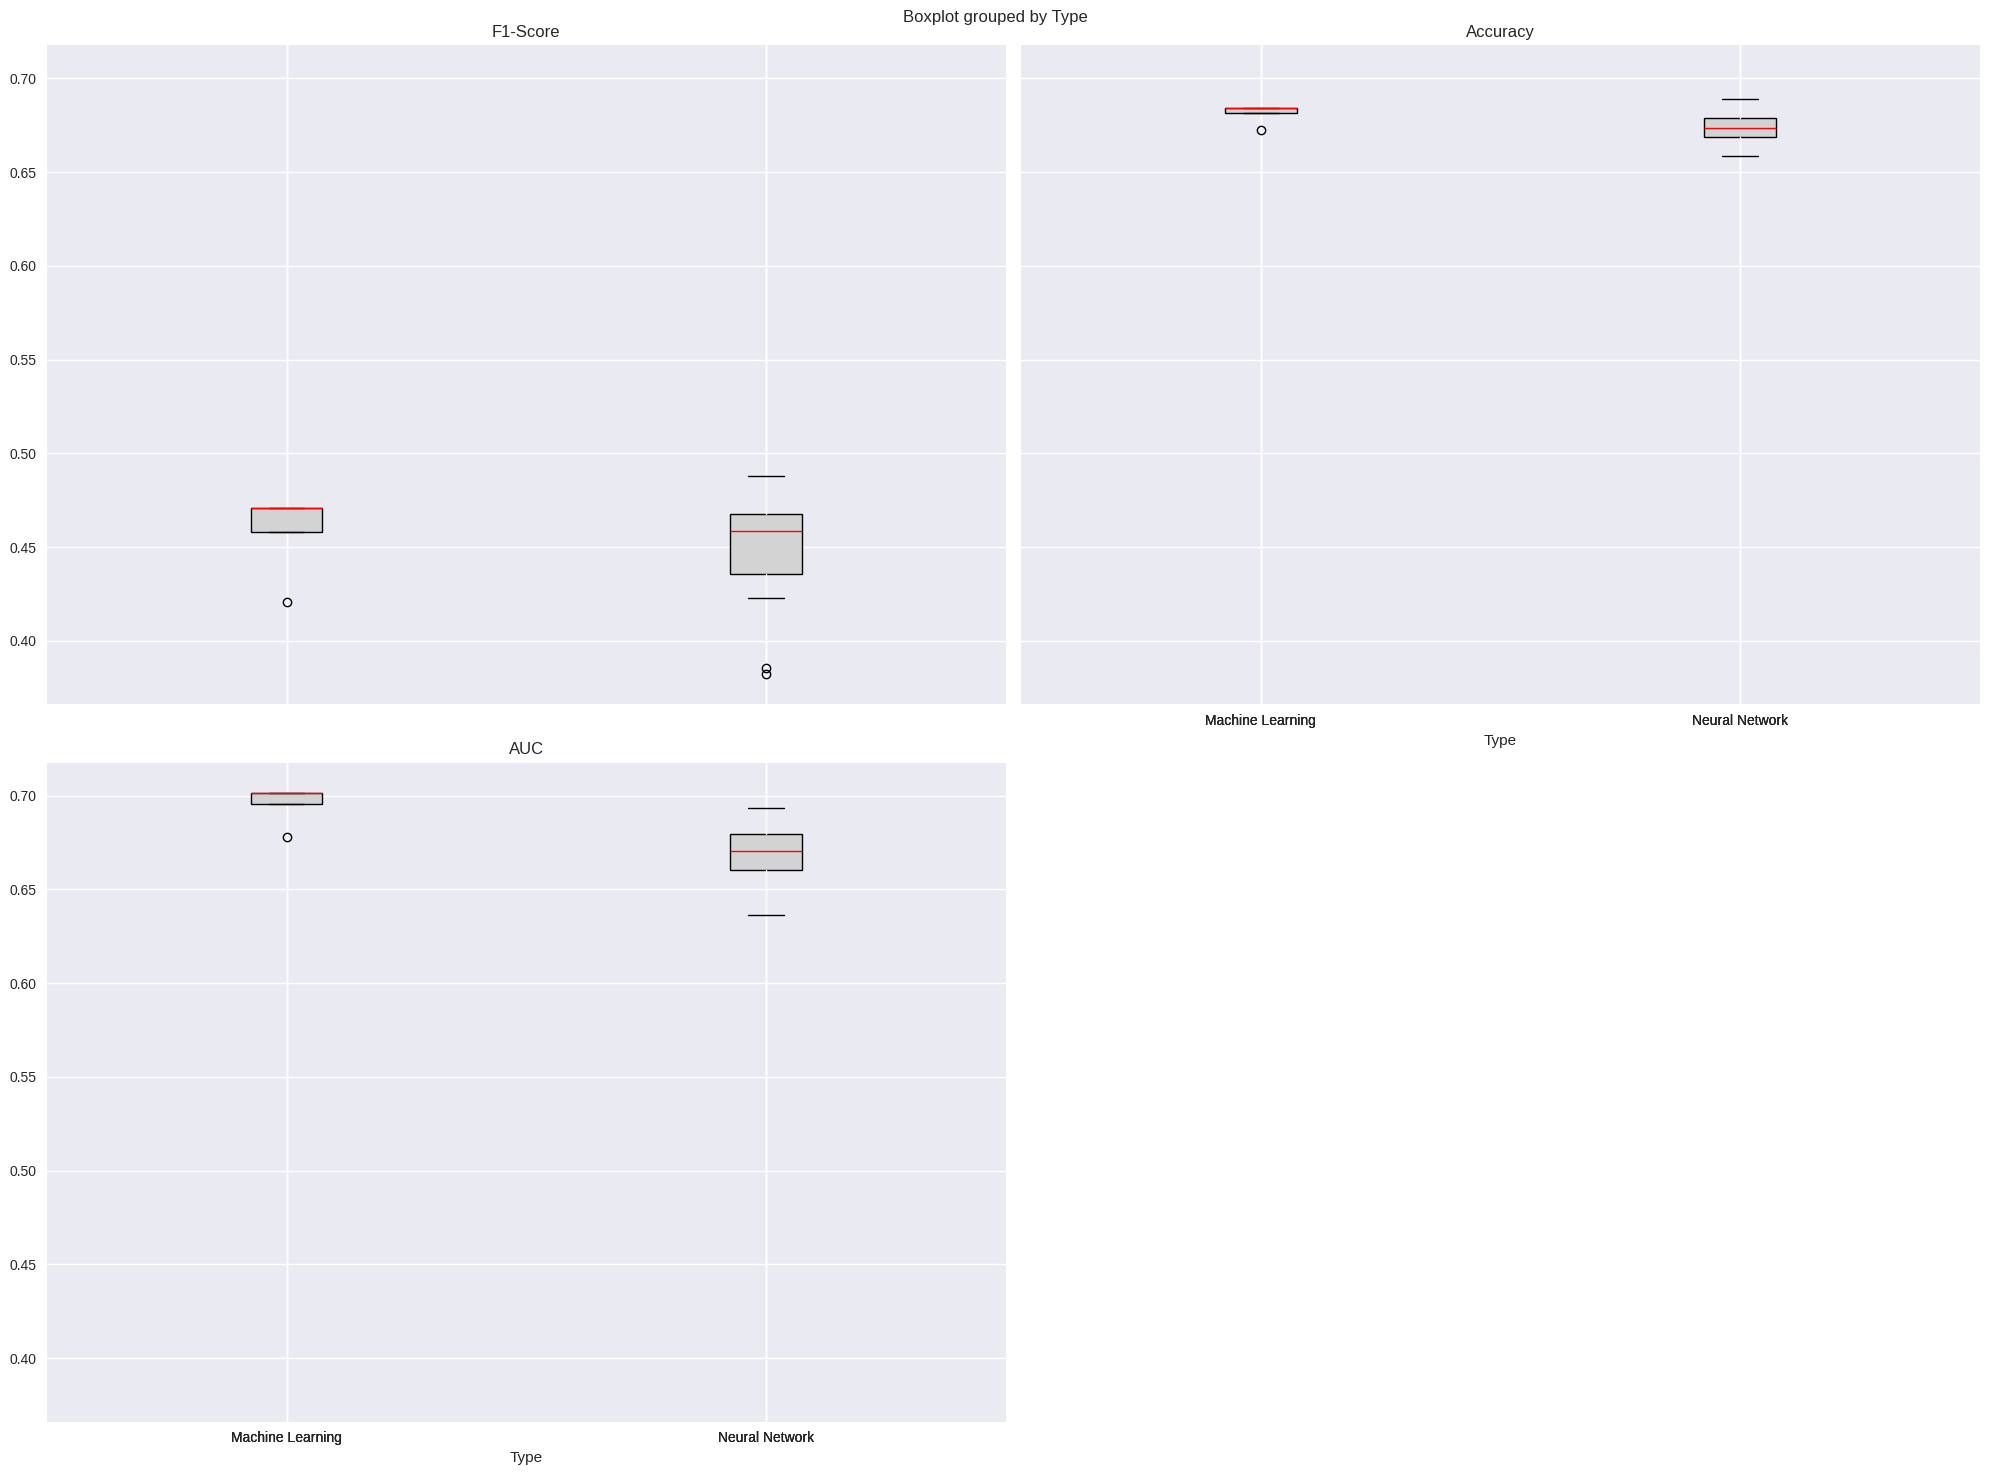

In [ ]:
fig, axes = plt.subplots(3, 4, figsize=(20, 15))

# 1. ROC Curves Comparison
models_to_compare = {
    'Best ML Model': best_ml_model[1],
    'Best NN Model': best_nn_model[1]
}

for i, (name, model_result) in enumerate(models_to_compare.items()):
    fpr, tpr, _ = roc_curve(model_result['y_test'], model_result['y_pred_proba'])
    auc_score = model_result.get('test_roc_auc', model_result.get('test_auc', None))
    axes[0, i].plot(fpr, tpr, linewidth=2, label=f'{name} (AUC = {auc_score:.3f})')
    axes[0, i].plot([0, 1], [0, 1], 'k--', alpha=0.5)
    axes[0, i].set_xlabel('False Positive Rate')
    axes[0, i].set_ylabel('True Positive Rate')
    axes[0, i].set_title(f'ROC Curve - {name}')
    axes[0, i].legend()
    axes[0, i].grid(True, alpha=0.3)

# 2. Precision-Recall Curves
for i, (name, model_result) in enumerate(models_to_compare.items()):
    precision, recall, _ = precision_recall_curve(model_result['y_test'], model_result['y_pred_proba'])
    avg_precision = average_precision_score(model_result['y_test'], model_result['y_pred_proba'])
    axes[0, i+2].plot(recall, precision, linewidth=2, label=f'{name} (AP = {avg_precision:.3f})')
    axes[0, i+2].set_xlabel('Recall')
    axes[0, i+2].set_ylabel('Precision')
    axes[0, i+2].set_title(f'Precision-Recall Curve - {name}')
    axes[0, i+2].legend()
    axes[0, i+2].grid(True, alpha=0.3)

# 3. Confusion Matrices
for i, (name, model_result) in enumerate(models_to_compare.items()):
    cm = confusion_matrix(model_result['y_test'], model_result['y_pred'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, i])
    axes[1, i].set_title(f'Confusion Matrix - {name}')
    axes[1, i].set_xlabel('Predicted')
    axes[1, i].set_ylabel('Actual')

# 4. Feature Importance (for best ML model)
if hasattr(best_ml_model[1]['model'], 'feature_importances_'):
    feature_names = preprocessing_results[best_ml_model[1]['feature_set']]['feature_names']
    importances = best_ml_model[1]['model'].feature_importances_
    indices = np.argsort(importances)[::-1][:20]  # Top 20 features

    axes[1, 2].barh(range(len(indices)), importances[indices])
    axes[1, 2].set_yticks(range(len(indices)))
    axes[1, 2].set_yticklabels([feature_names[i] for i in indices])
    axes[1, 2].set_title('Feature Importance - Best ML Model')
    axes[1, 2].set_xlabel('Importance')

# 5. Training History for best NN model
if 'history' in best_nn_model[1]:
    history = best_nn_model[1]['history']
    axes[1, 3].plot(history.history['loss'], label='Training Loss')
    axes[1, 3].plot(history.history['val_loss'], label='Validation Loss')
    axes[1, 3].set_title('Training History - Best NN Model')
    axes[1, 3].set_xlabel('Epoch')
    axes[1, 3].set_ylabel('Loss')
    axes[1, 3].legend()
    axes[1, 3].grid(True, alpha=0.3)

# 6. Model Performance Comparison
all_models_comparison = []

# Add ML models
for key, result in optimized_models.items():
    all_models_comparison.append({
        'Model': key.replace('_', ' '),
        'Type': 'Machine Learning',
        'F1-Score': result['test_f1'],
        'Accuracy': result['test_accuracy'],
        'AUC': result['test_roc_auc']
    })

# Add NN models
for key, result in nn_results.items():
    all_models_comparison.append({
        'Model': key.replace('_', ' '),
        'Type': 'Neural Network',
        'F1-Score': result['test_f1'],
        'Accuracy': result['test_accuracy'],
        'AUC': result['test_auc']
    })

comparison_df = pd.DataFrame(all_models_comparison)
top_10_models = comparison_df.nlargest(10, 'F1-Score')

# Bar plot of top 10 models
axes[2, 0].barh(range(len(top_10_models)), top_10_models['F1-Score'],
                color=['red' if x == 'Neural Network' else 'blue' for x in top_10_models['Type']])
axes[2, 0].set_yticks(range(len(top_10_models)))
axes[2, 0].set_yticklabels(top_10_models['Model'], fontsize=8)
axes[2, 0].set_title('Top 10 Models by F1-Score')
axes[2, 0].set_xlabel('F1-Score')

# 7. Model type comparison
type_comparison = comparison_df.groupby('Type')[['F1-Score', 'Accuracy', 'AUC']].mean()
type_comparison.plot(kind='bar', ax=axes[2, 1])
axes[2, 1].set_title('ML vs Neural Network Performance')
axes[2, 1].set_ylabel('Score')
axes[2, 1].tick_params(axis='x', rotation=45)

# 8. Performance distribution
comparison_df.boxplot(column=['F1-Score', 'Accuracy', 'AUC'], by='Type', ax=axes[2, 2], patch_artist=True,
                      boxprops=dict(facecolor='lightgray', color='black'), medianprops=dict(color='red'))
axes[2, 2].set_title('Performance Distribution by Model Type', fontsize=16)
axes[2, 2].set_xlabel('Model Type', fontsize=14)

# 9. Scatter plot: Accuracy vs F1-Score
for model_type in comparison_df['Type'].unique():
    subset = comparison_df[comparison_df['Type'] == model_type]
    axes[2, 3].scatter(subset['Accuracy'], subset['F1-Score'], label=model_type, alpha=0.7, s=70)
axes[2, 3].set_xlabel('Accuracy', fontsize=14)
axes[2, 3].set_ylabel('F1-Score', fontsize=14)
axes[2, 3].set_title('Accuracy vs F1-Score', fontsize=16)
axes[2, 3].legend()
axes[2, 3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Analysis:

1. F1-Score:
* Machine Learning models show higher and more consistent F1-scores compared to Neural Networks.
* Neural Networks have a wider range and more outliers, with several models scoring significantly lower.

2. Accuracy:
* Neural Networks have a slightly higher median accuracy than Machine Learning models.
* However, their accuracy distribution is broader, indicating lower stability across different configurations.
* While Neural Networks may achieve better peak accuracy, they are more sensitive to architecture and hyperparameters.

3. AUC:
* Machine Learning models have a higher and tighter distribution of AUC values.
* Neural Networks show more variability and generally lower AUC scores.


## Final Model Selection and Analysis

In [ ]:
# Select the overall best model based on F1 score
overall_best = max(
    list(optimized_models.items()) + list(nn_results.items()),
    key=lambda x: x[1]['test_f1']
)

print(f"OVERALL BEST MODEL: {overall_best[0]}")
print(f"Performance Metrics:")

# Printing the performance metrics
print(f" • Accuracy:  {overall_best[1]['test_accuracy']:.4f}")
print(f" • Precision: {overall_best[1].get('test_precision', 'N/A')}")
print(f" • Recall:    {overall_best[1].get('test_recall', 'N/A')}")
print(f" • F1-Score:  {overall_best[1]['test_f1']:.4f}")

# Handling AUC if it exists
auc_score = overall_best[1].get('test_roc_auc', 'N/A')
print(f" • AUC:       {auc_score:.4f}" if auc_score != 'N/A' else f" • AUC:       {auc_score}")


OVERALL BEST MODEL: ensemble_selected_wide_adam
Performance Metrics:
 • Accuracy:  0.6768
 • Precision: 0.6392405063291139
 • Recall:    0.39453125
 • F1-Score:  0.4879
 • AUC:       N/A


In [ ]:
from sklearn.metrics import classification_report

# Get the final test data and predictions
y_test_final = overall_best[1]['y_test']
y_pred_final = overall_best[1]['y_pred']

# 1. Detailed Classification Report
print(f"DETAILED CLASSIFICATION REPORT:")
print("-" * 40)
print(classification_report(y_test_final, y_pred_final,
                            target_names=['Not Potable', 'Potable']))

# 2. Model Interpretation and Insights
print(f"\n MODEL INSIGHTS:")
print("-" * 40)

# Print feature set and scaler used
if 'feature_set' in overall_best[1]:
    feature_set_used = overall_best[1]['feature_set']
    print(f"• Feature Set Used: {feature_set_used}")
    print(f"• Number of Features: {len(preprocessing_results[feature_set_used]['feature_names'])}")

if 'scaler' in overall_best[1]:
    print(f"• Scaling Method: {overall_best[1]['scaler']}")

# Display model type
model_type = 'Neural Network' if isinstance(overall_best[1]['model'], tf.keras.models.Model) else 'Machine Learning'
print(f"• Model Type: {model_type}")


DETAILED CLASSIFICATION REPORT:
----------------------------------------
              precision    recall  f1-score   support

 Not Potable       0.69      0.86      0.76       400
     Potable       0.64      0.39      0.49       256

    accuracy                           0.68       656
   macro avg       0.66      0.63      0.63       656
weighted avg       0.67      0.68      0.66       656


 MODEL INSIGHTS:
----------------------------------------
• Feature Set Used: ensemble_selected
• Number of Features: 32
• Scaling Method: robust
• Model Type: Neural Network


Analysis:

1. Overall Performance:
* **Accuracy**: The model achieved an accuracy of **68%**, indicating it correctly predicted the class for 68% of the total instances.
* **Weighted F1-Score**: **At 0.66**, this suggests a reasonable balance between precision and recall, accounting for class imbalance.

2. The model performs significantly better on the 'Not Potable' class, showing a bias likely due to class imbalance or insufficient feature representation for the "Potable" category.

3. Future work: Consider applying class balancing techniques, tuning the loss function, or adjusting decision thresholds to improve minority class performance.